In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Dataset path
dataset_path = r"C:\Users\DELL\Desktop\Fourth Year\Semester1\Deep Learning\weather"

# Load the full dataset
full_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    image_size=(224, 224),
    batch_size=32,
    shuffle=True
)

# Get class names
class_names = full_dataset.class_names
num_classes = len(class_names)

# Split the dataset into train, validation, and test sets
total_size = tf.data.experimental.cardinality(full_dataset).numpy()
train_size = int(0.7 * total_size)  # 70% training
val_size = int(0.15 * total_size)  # 15% validation
test_size = total_size - train_size - val_size  # 15% testing

train_dataset = full_dataset.take(train_size)
remaining_dataset = full_dataset.skip(train_size)
val_dataset = remaining_dataset.take(val_size)
test_dataset = remaining_dataset.skip(val_size)

Found 6862 files belonging to 11 classes.


In [3]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.2),
])

# Normalize the datasets
normalization_layer = tf.keras.layers.Rescaling(1./255)

def preprocess_data(dataset, augmentation=False):
    if augmentation:
        dataset = dataset.map(lambda x, y: (data_augmentation(x), y))
    dataset = dataset.map(lambda x, y: (normalization_layer(x), y))
    return dataset

# Apply the preprocessing pipeline
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = preprocess_data(train_dataset, augmentation=True).prefetch(buffer_size=AUTOTUNE)
val_dataset = preprocess_data(val_dataset, augmentation=False).prefetch(buffer_size=AUTOTUNE)
test_dataset = preprocess_data(test_dataset, augmentation=False).prefetch(buffer_size=AUTOTUNE)

In [4]:
# Define the ResNet Block
class ResNetBlock(Layer):
    def __init__(self, out_channels, first_stride=1):
        super(ResNetBlock, self).__init__()
        self.conv1 = Conv2D(out_channels, 3, strides=first_stride, padding='same')
        self.bn1 = BatchNormalization()
        self.relu = ReLU()
        self.conv2 = Conv2D(out_channels, 3, strides=1, padding='same')
        self.bn2 = BatchNormalization()

        # Adjust dimensions for skip connection if necessary
        self.skip = Sequential()
        if first_stride != 1:
            self.skip.add(Conv2D(out_channels, 1, strides=first_stride))
            self.skip.add(BatchNormalization())

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)

        skip = self.skip(inputs) if hasattr(self.skip, 'layers') else inputs
        return self.relu(x + skip)

In [5]:
# Define the ResNet model
class ResNet(Model):
    def __init__(self, num_classes):
        super(ResNet, self).__init__()
        self.conv1 = Sequential([
            Conv2D(64, 7, strides=2, padding='same'),
            BatchNormalization(),
            ReLU(),
            MaxPooling2D(3, strides=2, padding='same')
        ])

        self.res_blocks = Sequential([
            ResNetBlock(64),
            ResNetBlock(64),
            ResNetBlock(128, first_stride=2),
            ResNetBlock(128),
            ResNetBlock(256, first_stride=2),
            ResNetBlock(256),
            ResNetBlock(512, first_stride=2),
            ResNetBlock(512),
        ])

        self.global_pool = GlobalAveragePooling2D()
        self.fc = Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.res_blocks(x)
        x = self.global_pool(x)
        return self.fc(x)

In [6]:
# Create and compile the model
model = ResNet(num_classes)
model.build((None, 224, 224, 3))
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()



Model: "res_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 56, 56, 64)        9728      
                                                                 
 sequential_10 (Sequential)  (None, 7, 7, 512)         11181184  
                                                                 
 global_average_pooling2d (  multiple                  0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               multiple                  5643      
                                                                 
Total params: 11196555 (42.71 MB)
Trainable params: 11186955 (42.67 MB)
Non-trainable params: 9600 (37.50 KB)
_________________________________________________________________


In [7]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, verbose=1)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/20

150/150 [==============================] - 299s 2s/step - loss: 1.6620 - accuracy: 0.4740 - val_loss: 11.5823 - val_accuracy: 0.1191 - lr: 0.0010
Epoch 2/20
150/150 [==============================] - 333s 2s/step - loss: 1.3541 - accuracy: 0.5346 - val_loss: 2.9125 - val_accuracy: 0.2832 - lr: 0.0010
Epoch 3/20
150/150 [==============================] - 337s 2s/step - loss: 1.2287 - accuracy: 0.5819 - val_loss: 1.8906 - val_accuracy: 0.4609 - lr: 0.0010
Epoch 4/20
150/150 [==============================] - 328s 2s/step - loss: 1.1559 - accuracy: 0.6094 - val_loss: 1.5400 - val_accuracy: 0.4912 - lr: 0.0010
Epoch 5/20
150/150 [==============================] - 326s 2s/step - loss: 1.1083 - accuracy: 0.6210 - val_loss: 2.1119 - val_accuracy: 0.4346 - lr: 0.0010
Epoch 6/20
150/150 [==============================] - ETA: 0s - loss: 1.1057 - accuracy: 0.6267
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
150/150 [==============================] - 328

In [9]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc}")

33/33 [==============================] - 24s 425ms/step - loss: 0.7963 - accuracy: 0.7100
Test Accuracy: 0.7100192904472351


In [10]:
# Generate predictions on the test set
y_true, y_pred = [], []
for images, labels in test_dataset:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

# Classification Report
print(classification_report(y_true, y_pred, target_names=class_names))

1/1 [==============================] - 1s 726ms/step
              precision    recall  f1-score   support

         dew       0.82      0.87      0.84        90
     fogsmog       0.82      0.75      0.78       118
       frost       0.33      0.75      0.46        64
       glaze       0.50      0.17      0.25       100
        hail       0.88      0.57      0.69        93
   lightning       0.77      0.96      0.85        48
        rain       0.62      0.89      0.73        76
     rainbow       1.00      0.73      0.85        41
        rime       0.79      0.85      0.82       206
   sandstorm       0.78      0.87      0.82        99
        snow       0.73      0.45      0.55       103

    accuracy                           0.71      1038
   macro avg       0.73      0.71      0.70      1038
weighted avg       0.74      0.71      0.70      1038



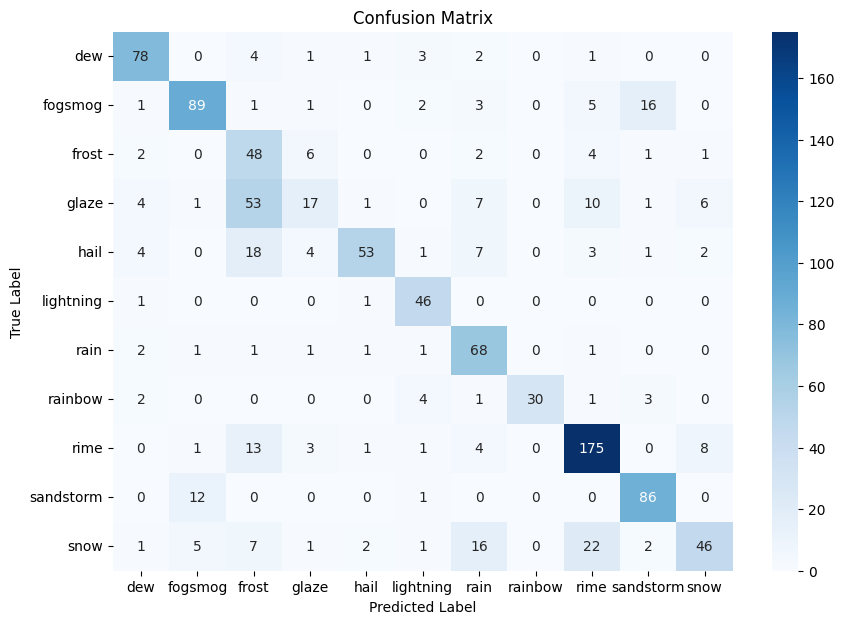

In [11]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

1/1 [==============================] - 0s 262ms/step


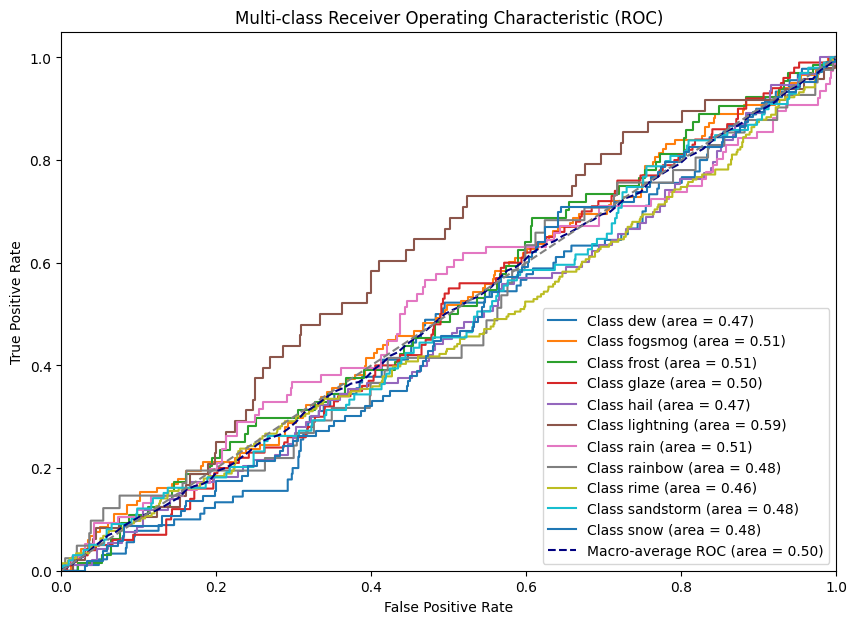

In [12]:
# One-hot encode the true labels
y_true_one_hot = label_binarize(y_true, classes=range(num_classes))

# Get predicted probabilities for each class
y_pred_prob = []
for images, _ in test_dataset:
    predictions = model.predict(images)
    y_pred_prob.extend(predictions)

y_pred_prob = np.array(y_pred_prob)

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_one_hot[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC curve and AUC
fpr["macro"], tpr["macro"] = np.linspace(0, 1, 100), np.zeros(100)
for i in range(num_classes):
    tpr["macro"] += np.interp(fpr["macro"], fpr[i], tpr[i])

tpr["macro"] /= num_classes
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot ROC curves for all classes and macro-average
plt.figure(figsize=(10, 7))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {class_names[i]} (area = {roc_auc[i]:.2f})')

plt.plot(fpr["macro"], tpr["macro"], label=f'Macro-average ROC (area = {roc_auc["macro"]:.2f})', color='navy', linestyle='--')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

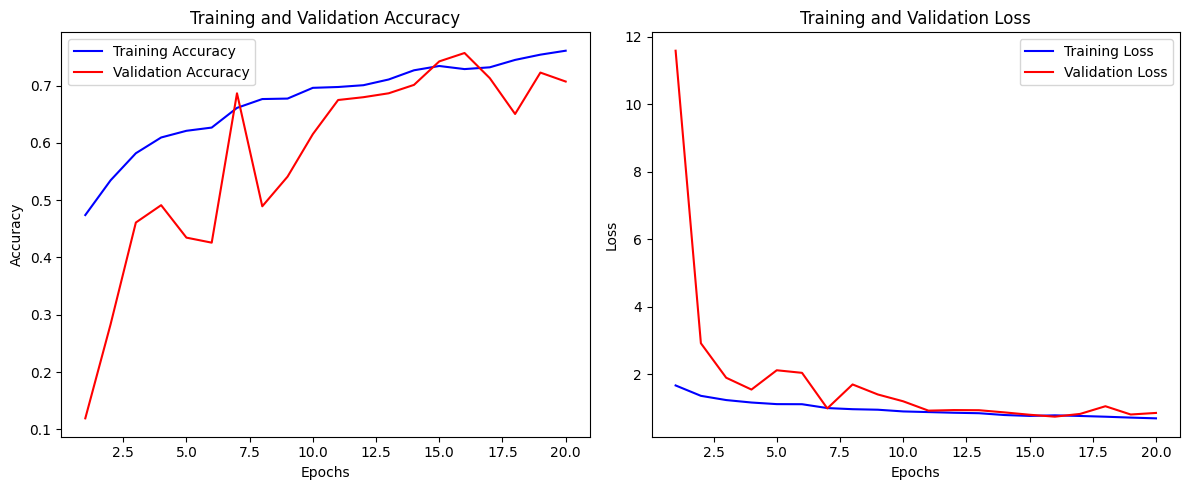

In [13]:
# Plot Training Curves for Accuracy and Loss
def plot_training_curves(history):
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']
    loss, val_loss = history.history['loss'], history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Accuracy plot
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_curves(history)